MATH 448  
HOMEWORK CH 8  
Andrew Dahlstrom  
5/18/24  


4) a. b. See diagrams drawn on seperate page

In [1]:
# 8)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
import matplotlib.pyplot as plt


carseats_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MATH 448/Carseats.csv')
carseats_df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [2]:
# Split the data into predictors and response
X = carseats_df.drop('Sales', axis=1)
y = carseats_df['Sales']

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

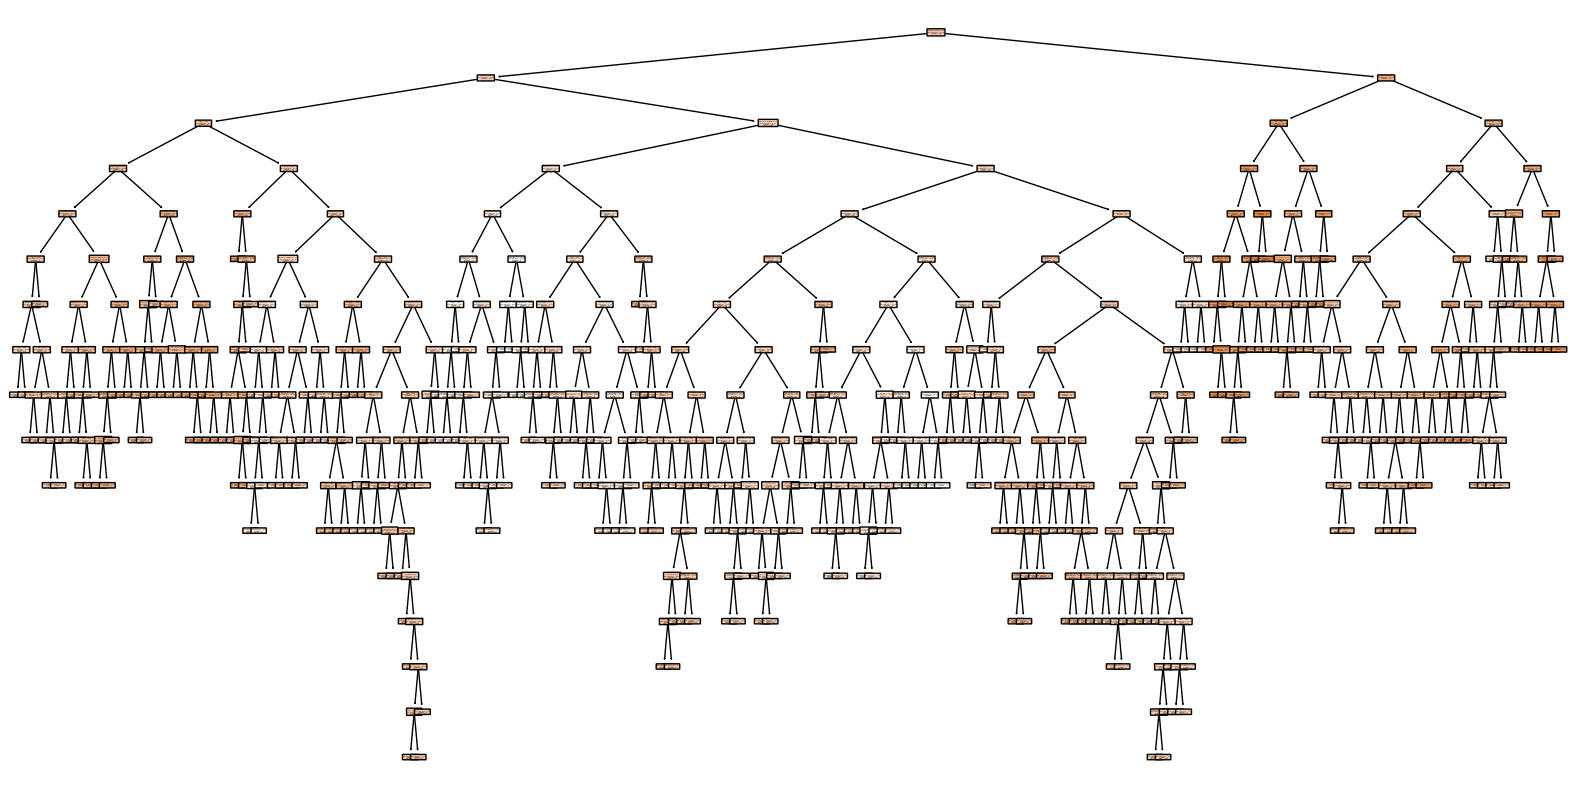

Test MSE: 6.071365


In [3]:
# Fit a regression tree to the training set
tree_reg = DecisionTreeRegressor(random_state=5)
tree_reg.fit(X_train, y_train)

# Plot the regression tree
plt.figure(figsize=(20,10))
plot_tree(tree_reg, feature_names=X.columns, filled=True, rounded=True)
plt.show()

# Evaluate the tree on the test set
y_pred = tree_reg.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
print(f'Test MSE: {mse_test}')

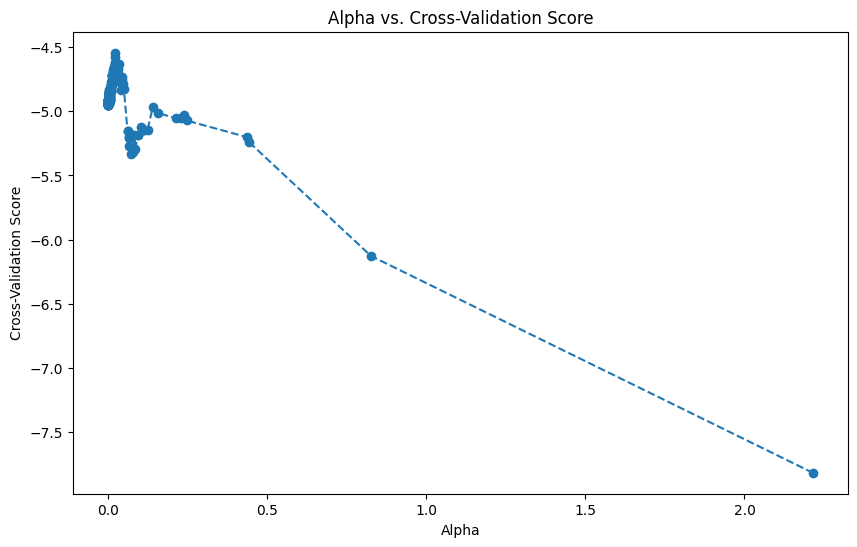

Optimal Alpha: 0.020657232142856904
Test MSE after pruning: 5.594351237231633


In [4]:
# Perform cross-validation to find the optimal tree size
path = tree_reg.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Train trees for each alpha and compute the cross-validation scores
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=5, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

# Determine the best alpha using cross-validation
alpha_scores = [cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean() for clf in clfs]

# Plot alpha vs. cross-validation scores
plt.figure(figsize=(10,6))
plt.plot(ccp_alphas, alpha_scores, marker='o', linestyle='--')
plt.xlabel('Alpha')
plt.ylabel('Cross-Validation Score')
plt.title('Alpha vs. Cross-Validation Score')
plt.show()

# Find the optimal alpha
optimal_alpha = ccp_alphas[np.argmax(alpha_scores)]
print(f'Optimal Alpha: {optimal_alpha}')

# Fit the pruned tree with the optimal alpha
tree_reg_pruned = DecisionTreeRegressor(random_state=5, ccp_alpha=optimal_alpha)
tree_reg_pruned.fit(X_train, y_train)

# Evaluate the pruned tree on the test set
y_pred_pruned = tree_reg_pruned.predict(X_test)
mse_test_pruned = mean_squared_error(y_test, y_pred_pruned)
print(f'Test MSE after pruning: {mse_test_pruned}')

Pruning did improve the test MSE from 6.071365 before pruning to 5.5943512 afterwards.

In [7]:
# Bagging approach
bag_reg = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100, random_state=5)
bag_reg.fit(X_train, y_train)

# Evaluate the bagging model on the test set
y_pred_bag = bag_reg.predict(X_test)
mse_test_bag = mean_squared_error(y_test, y_pred_bag)
print(f'Test MSE after bagging: {mse_test_bag}')

# Feature importances
feature_importances_bag = np.mean([tree.feature_importances_ for tree in bag_reg.estimators_], axis=0)
feature_importances_df_bag = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_bag})
feature_importances_df_bag = feature_importances_df_bag.sort_values(by='Importance', ascending=False)
print('Feature Importances:\n', feature_importances_df_bag)

Test MSE after bagging: 2.3374359749999996
Feature Importances:
              Feature  Importance
4              Price    0.280711
7     ShelveLoc_Good    0.265508
0          CompPrice    0.103547
5                Age    0.090883
2        Advertising    0.077199
1             Income    0.053703
8   ShelveLoc_Medium    0.048423
3         Population    0.037333
6          Education    0.029750
10            US_Yes    0.008217
9          Urban_Yes    0.004727


Test MSE with Random Forest: 2.3278507305000002
Feature Importances (Random Forest):
              Feature  Importance
4              Price    0.280344
7     ShelveLoc_Good    0.265508
0          CompPrice    0.103759
5                Age    0.091585
2        Advertising    0.076802
1             Income    0.054033
8   ShelveLoc_Medium    0.048316
3         Population    0.037327
6          Education    0.029041
10            US_Yes    0.008828
9          Urban_Yes    0.004459


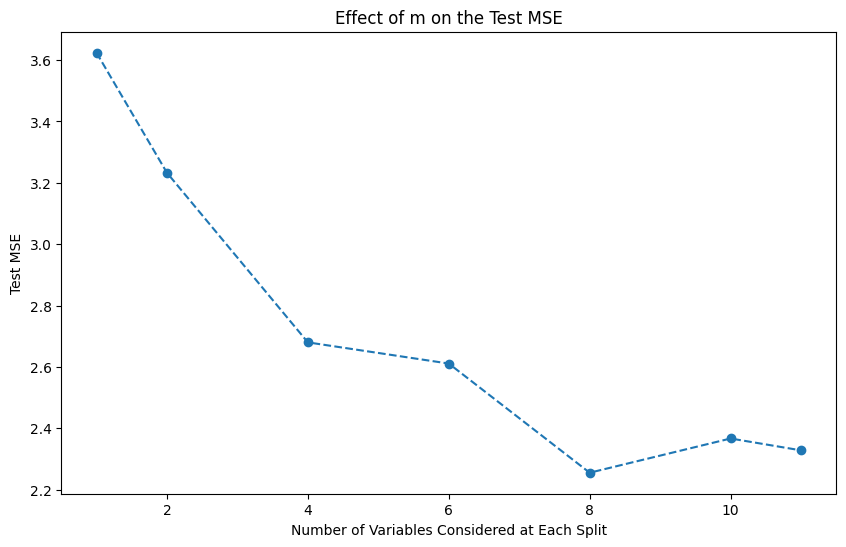

In [8]:
# Random forest approach
rf_reg = RandomForestRegressor(n_estimators=100, random_state=5)
rf_reg.fit(X_train, y_train)

# Evaluate the random forest model on the test set
y_pred_rf = rf_reg.predict(X_test)
mse_test_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Test MSE with Random Forest: {mse_test_rf}')

# Feature importances
feature_importances_rf = rf_reg.feature_importances_
feature_importances_df_rf = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_rf})
feature_importances_df_rf = feature_importances_df_rf.sort_values(by='Importance', ascending=False)
print('Feature Importances (Random Forest):\n', feature_importances_df_rf)

# Analyze the effect of m (number of variables considered at each split)
m_values = [1, 2, 4, 6, 8, 10, 11]
mse_rf_m = []

for m in m_values:
    rf_reg_m = RandomForestRegressor(n_estimators=100, max_features=m, random_state=5)
    rf_reg_m.fit(X_train, y_train)
    y_pred_rf_m = rf_reg_m.predict(X_test)
    mse_rf_m.append(mean_squared_error(y_test, y_pred_rf_m))

# Plot the effect of m on the error rate
plt.figure(figsize=(10,6))
plt.plot(m_values, mse_rf_m, marker='o', linestyle='--')
plt.xlabel('Number of Variables Considered at Each Split')
plt.ylabel('Test MSE')
plt.title('Effect of m on the Test MSE')
plt.show()

Looking at the graph above for the number of variable to split the tree on compared to the test MSE for that tree, we can see that increasing the number of variables decreases the error rate until 8 variable which achieves the lowesttest MSE then the error increases slightly with more variables 10 and 11.

In [10]:
# 10)

hitters_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MATH 448/Hitters.csv')

# Remove observations with unknown salary
hitters_df = hitters_df.dropna(subset=['Salary'])

# Log-transform the salaries
hitters_df['Salary'] = np.log(hitters_df['Salary'])

hitters_df.head()

<ipython-input-10-aea12a1d89fa>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Salary'] = np.log(data['Salary'])


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,6.163315,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,6.173786,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,6.214608,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,4.516339,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,6.620073,A


In [11]:
# Create a training set of first 200 observations
train = hitters_df.iloc[:200]
test = hitters_df.iloc[200:]

# Split data into predictors and response
X_train = train.drop('Salary', axis=1)
y_train = train['Salary']
X_test = test.drop('Salary', axis=1)
y_test = test['Salary']

# Convert categorical variables to dummy variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align columns in test set with training set
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

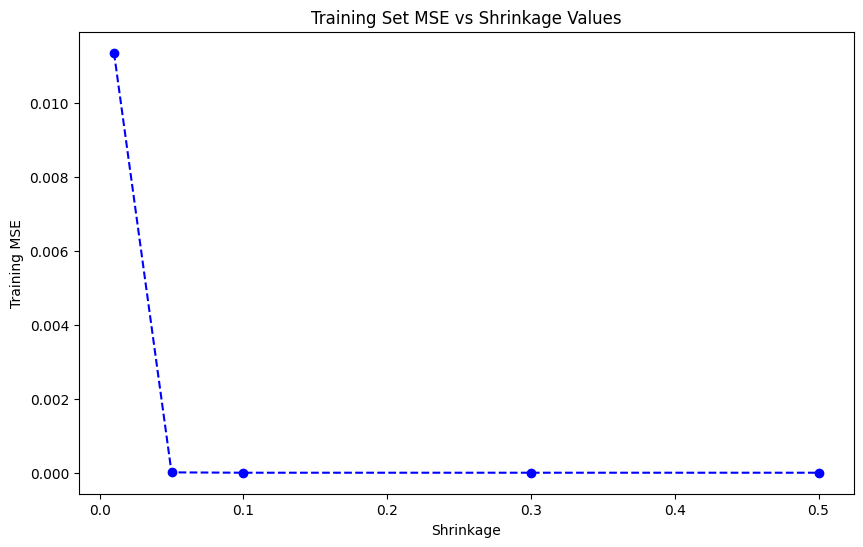

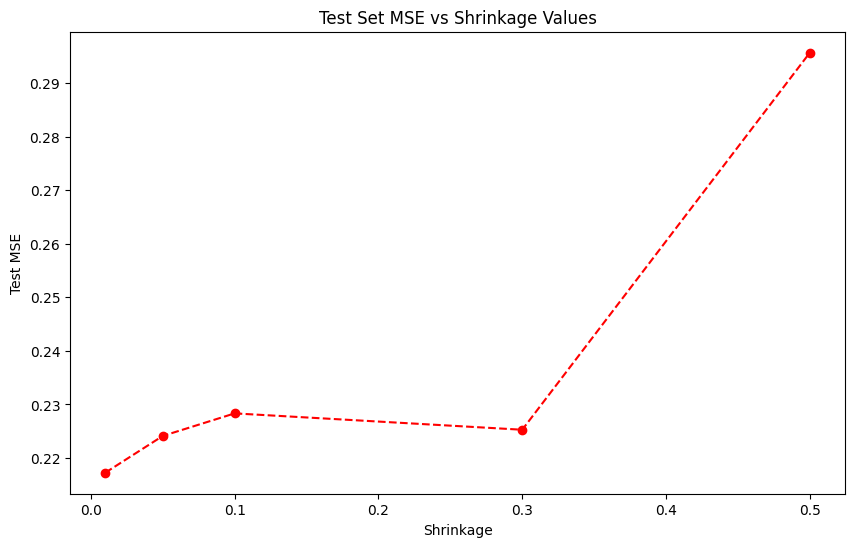

In [12]:
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor
# Perform boosting using different values of lambda
shrinkage_values = [0.01, .05, 0.1, 0.3, 0.5]
train_mse = []
test_mse = []

for shrinkage in shrinkage_values:
    gbm = GradientBoostingRegressor(n_estimators=1000, learning_rate=shrinkage, random_state=5)
    gbm.fit(X_train, y_train)

    # Calculate MSE for training set
    y_train_pred = gbm.predict(X_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    train_mse.append(mse_train)

    # Calculate MSE for test set
    y_test_pred = gbm.predict(X_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    test_mse.append(mse_test)

# Plot training set MSE vs shrinkage values
plt.figure(figsize=(10, 6))
plt.plot(shrinkage_values, train_mse, marker='o', linestyle='--', color='b')
plt.xlabel('Shrinkage')
plt.ylabel('Training MSE')
plt.title('Training Set MSE vs Shrinkage Values')
plt.show()

# Plot test set MSE vs. shrinkage values
plt.figure(figsize=(10, 6))
plt.plot(shrinkage_values, test_mse, marker='o', linestyle='--', color='r')
plt.xlabel('Shrinkage')
plt.ylabel('Test MSE')
plt.title('Test Set MSE vs Shrinkage Values')
plt.show()

In [13]:
from sklearn.linear_model import LinearRegression, LassoCV
# Two additional approaches
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_test_pred_lin = lin_reg.predict(X_test)
mse_test_lin = mean_squared_error(y_test, y_test_pred_lin)
print(f'Test MSE with Linear Regression: {mse_test_lin}')

# Linear Regression with Lasso
lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)
y_test_pred_lasso = lasso.predict(X_test)
mse_test_lasso = mean_squared_error(y_test, y_test_pred_lasso)
print(f'Test MSE with Lasso Regression: {mse_test_lasso}')

Test MSE with Linear Regression: 0.4917959375454945
Test MSE with Lasso Regression: 0.4865863696030245


From the Gradient Boosting Regressor a test MSE of about .22 was achieved with a shrinkage lambda of .01. This performed better than Linear Regression or Linear Regression with Lasso which had a test MSE of about .49

In [14]:
# Use the best performing boosting model to determine feature importances
best_shrinkage = shrinkage_values[np.argmin(test_mse)]
best_gbm = GradientBoostingRegressor(n_estimators=1000, learning_rate=best_shrinkage, random_state=5)
best_gbm.fit(X_train, y_train)

# Get feature importances
feature_importances = best_gbm.feature_importances_
feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
print('Feature Importances:\n', feature_importances_df)

Feature Importances (Boosting):
         Feature  Importance
7        CAtBat    0.532620
8         CHits    0.090809
0         AtBat    0.051320
10        CRuns    0.051173
5         Walks    0.044683
11         CRBI    0.039405
12       CWalks    0.035994
9        CHmRun    0.034842
6         Years    0.028417
1          Hits    0.024480
4           RBI    0.020765
13      PutOuts    0.014102
3          Runs    0.011052
15       Errors    0.007113
2         HmRun    0.005147
14      Assists    0.004383
18  NewLeague_N    0.002186
17   Division_W    0.000804
16     League_N    0.000704


CAtBat is the most important predictor with a importance score of .53 then followed by CHits with a score of .09

In [16]:
# Use bagging approach
bag_reg = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100, random_state=42)
bag_reg.fit(X_train, y_train)

# Evaluate bagging model on test set
y_pred_bag = bag_reg.predict(X_test)
mse_test_bag = mean_squared_error(y_test, y_pred_bag)
print(f'Test MSE with Bagging: {mse_test_bag}')

Test MSE with Bagging: 0.23497077190425542


The test MSE with bagging was .23 which is slightly higher than the test MSE of the Gradient Boosting Regressorusing a shrinkage lambda of .01 with a test MSE of about .22